In [64]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

,Date,Close,High,Low,Open,Volume
0,2024-01-02,184.532074,187.315366,182.792518,186.033057,82488700
1,2024-01-03,183.150391,184.770668,182.335277,183.120571,58414500
2,2024-01-04,180.824356,181.997307,179.800504,181.062914,71983600
3,2024-01-05,180.098694,181.669266,179.094727,180.903872,62303300
4,2024-01-08,184.452560,184.492330,180.416793,181.003268,59144500
...,...,...,...,...,...,...
246,2024-12-23,254.989655,255.369227,253.171646,254.490204,40858800
247,2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700
248,2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100
249,2024-12-27,255.309296,258.415896,252.782075,257.546826,42355300


In [141]:
appl = pd.read_csv("appleStockPrices.csv")

appl['returns'] = appl['Close'].pct_change()
appl['previous1DayReturn'] = appl['returns'].shift(1)
appl['previous2DayReturn'] = appl['returns'].shift(2)
appl['previous3DayReturn'] = appl['returns'].shift(3)
appl['previous4DayReturn'] = appl['returns'].shift(4)
appl['previous5DayReturn'] = appl['returns'].shift(5)

appl = appl.dropna()
cutoffDate = '2024-12-01'
train = appl[appl['Date'] < cutoffDate]
test = appl[appl['Date'] >= cutoffDate]

forecast = []

def nDayReturnPattern(n, df):
    return [tuple(
        df.iloc[i][f'previous{j}DayReturn']>0 for j in range(1, n+1))
            for i in range(len(df)
    )]

N = 2

trainNDayReturnPattern = nDayReturnPattern(N, train)
testNDayReturnPattern = nDayReturnPattern(N, test)

for _ in range(5000):
    for i in range(len(test)):
        previousNdayReturnPattern = testNDayReturnPattern[i]
        # sample from the training set GIVEN the previous 3 day return patterns
        filter = [pattern == previousNdayReturnPattern for pattern in trainNDayReturnPattern]
        sample = train[filter]

        if not sample.empty:
            r = sample['returns'].sample(1).values[0]
        else:
            r = train['returns'].sample(1).values[0]
        forecast.append(r)

    forcastedPrice = test['Close'].values[0] * (1 + np.array(forecast))
    forecastAccuracy = np.mean(np.sign(forecast) == np.sign(test['returns'].values))
avgForecastAccuracy = np.mean(forecastAccuracy)
print(f"Avg Forecast Accuracy: {avgForecastAccuracy}")

/var/folders/bt/709h7c513ld30l7ynqg_cv0c0000gn/T/ipykernel_48062/700297519.py:42: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



Avg Forecast Accuracy: 0.0


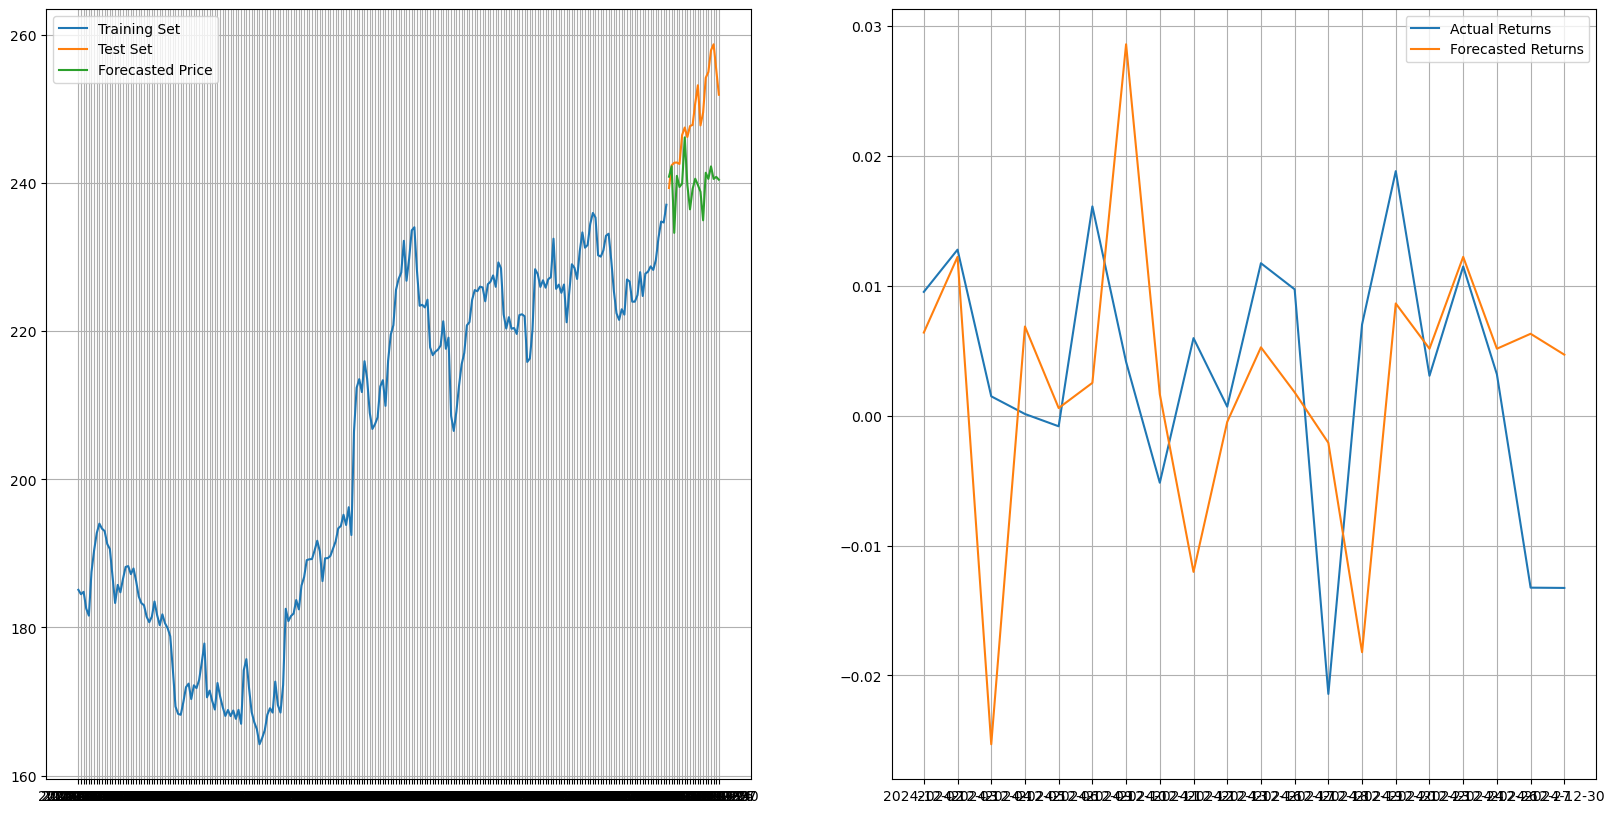

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(train['Date'], train['Close'], label='Training Set')
ax[0].plot(test['Date'], test['Close'], label='Test Set')
ax[0].plot(test['Date'], forcastedPrice, label='Forecasted Price')
ax[0].legend()
ax[0].grid()

ax[1].plot(test['Date'], test['returns'], label='Actual Returns')
ax[1].plot(test['Date'], forecast, label='Forecasted Returns')
ax[1].legend()
ax[1].grid()

In [56]:
# use plotly to plot the forecasted price
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['Date'], y=train['Close'], mode='lines', name='Training Set'))
fig.add_trace(go.Scatter(x=test['Date'], y=test['Close'], mode='lines', name='Test Set'))
fig.add_trace(go.Scatter(x=test['Date'], y=forcastedPrice, mode='lines', name='Forecasted Price'))
fig.update_layout(title='Forecasted Price', xaxis_title='Date', yaxis_title='Price')
pio.show(fig)

In [150]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def knn_forecast(train, test, n=3, k=5):
    # Create feature matrix from previous n-day returns
    train_X = train[[f'previous{i}DayReturn' for i in range(1, n+1)]].values
    test_X = test[[f'previous{i}DayReturn' for i in range(1, n+1)]].values
    train_y = train['returns'].values

    # Fit Nearest Neighbors model
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    nn.fit(train_X)

    # For each test point, find k-nearest neighbors and average their returns
    neighbors = nn.kneighbors(test_X, return_distance=False)

    forecast = []
    for idx_list in neighbors:
        neighbor_returns = train_y[idx_list]
        forecast.append(np.mean(neighbor_returns))  # or np.median(), or sample randomly

    test = test.copy()
    test['forecast_return_knn'] = forecast
    return test

In [160]:
knn_forecasted = knn_forecast(train, test, n=4, k=10)
forecastedPriceKNN = test['Close'].values[0] * (1 + knn_forecasted['forecast_return_knn'].values)
forecastAccuracyKNN = np.mean(np.sign(knn_forecasted['forecast_return_knn'].values) == np.sign(test['returns'].values))
print(f"Avg Forecast Accuracy KNN: {forecastAccuracyKNN}")

Avg Forecast Accuracy KNN: 0.5


In [148]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['Date'], y=train['Close'], mode='lines', name='Training Set'))
fig.add_trace(go.Scatter(x=test['Date'], y=test['Close'], mode='lines', name='Test Set'))
fig.add_trace(go.Scatter(x=test['Date'], y=knn_forecasted['forecast_return_knn'], mode='lines', name='KNN Forecasted Returns'))
fig.update_layout(title='KNN Forecasted Returns', xaxis_title='Date', yaxis_title='Returns')
pio.show(fig)
